### Processing CIR


Color infrared (CIR) imagery, also known as false-color imagery, the near-infrared (NIR) band is typically assigned to a channel that would ordinarily represent red in true-color imagery. This means that the red, green, and blue (RGB) channels are shifted in the NIR photographs. The NIR band is used instead of the red band, the red band shifts to the place of the green band, and the green band moves to the blue band's position. 

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, sys
sys.path.append('../scripts/')
import rasterio
import random
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

import create_patches_from_polygons_data as cpd

/home/david/anaconda3/envs/geo/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/david/anaconda3/envs/geo/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/david/anaconda3/envs/geo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Resize raster

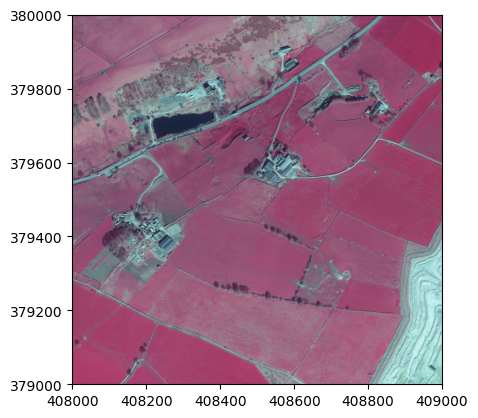

<Axes: >

In [13]:
src = rasterio.open("/home/david/Documents/ADP/50cm Colour Infrared/SK0879.tif") 
show(src)

In [14]:
# Accessing raster details
print("Raster width in pixels:", src.width)
print("Raster height in pixels:", src.height)
print("Number of bands:", src.count)
print("Data type of each band:", src.dtypes)

Raster width in pixels: 2000
Raster height in pixels: 2000
Number of bands: 3
Data type of each band: ('uint8', 'uint8', 'uint8')


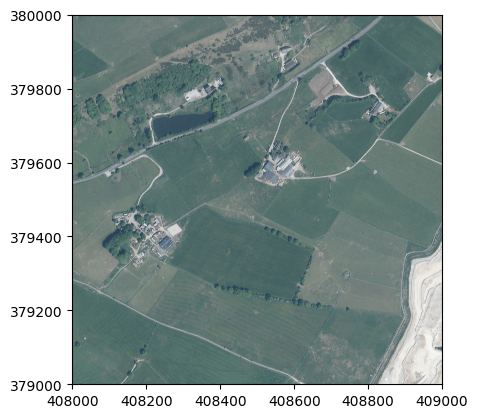

<Axes: >

In [18]:
from rasterio.plot import show
rgb = rasterio.open("/home/david/Documents/ADP/RGB_12.5cm/SK0879.tif)"
show(rgb)

In [19]:
# Accessing raster details
print("Raster width in pixels:", rgb.width)
print("Raster height in pixels:", rgb.height)
print("Number of bands:", rgb.count)
print("Data type of each band:", rgb.dtypes)

Raster width in pixels: 8000
Raster height in pixels: 8000
Number of bands: 3
Data type of each band: ('uint8', 'uint8', 'uint8')


## Resizing using bilinear interpolation 

In [21]:
from rasterio.enums import Resampling

# Open the color infrared raster file
src = rasterio.open("/home/david/Documents/ADP/50cm Colour Infrared/SK0879.tif")

# Target dimensions
target_width = 8000
target_height = 8000

# Resampling method
resampling_method = Resampling.bilinear

# Compute the scale factors for resizing
scale_x = target_width / src.width
scale_y = target_height / src.height

# Perform the resizing
data = src.read(
    out_shape=(src.count, target_height, target_width),
    resampling=resampling_method
)

# Update the metadata for the resized raster
transform = src.transform * src.transform.scale(
    (src.width / target_width),
    (src.height / target_height)
)

# Update the width and height
new_width, new_height = target_width, target_height

# Update the src profile
profile = src.profile
profile.update(width=new_width, height=new_height, transform=transform)

# Save or process the resized data
# For example, you can save it to a new raster file
with rasterio.open("/home/david/Documents/ADP/test/resized_cir_image.tif", "w", **profile) as dst:
    dst.write(data)

# Close the source raster
src.close()

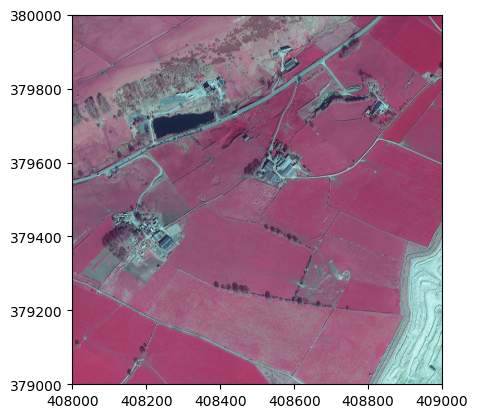

<Axes: >

In [22]:
from rasterio.plot import show
cir_resize = rasterio.open("/home/david/Documents/ADP/test/resized_cir_image.tif")
show(cir_resize)

In [23]:
# Accessing raster details
print("Raster width in pixels:", cir_resize.width)
print("Raster height in pixels:", cir_resize.height)
print("Number of bands:", cir_resize.count)
print("Data type of each band:", cir_resize.dtypes)

Raster width in pixels: 8000
Raster height in pixels: 8000
Number of bands: 3
Data type of each band: ('uint8', 'uint8', 'uint8')


## Batch process the 80 train and test tiles

In [26]:
# Define source and target directories
source_dir = "/home/david/Documents/ADP/50cm Colour Infrared/"
target_dir = "/home/david/Documents/ADP/CIR_12.5cm/"

# Target dimensions
target_width = 8000
target_height = 8000

# Resampling method
resampling_method = Resampling.bilinear

# Iterate over each file in the source directory
for filename in os.listdir(source_dir):
    # Check if the file is a TIFF file
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        # Open the source raster file
        src_path = os.path.join(source_dir, filename)
        src = rasterio.open(src_path)

        # Compute the scale factors for resizing
        scale_x = target_width / src.width
        scale_y = target_height / src.height

        # Perform the resizing
        data = src.read(
            out_shape=(src.count, target_height, target_width),
            resampling=resampling_method
        )

        # Update the metadata for the resized raster
        transform = src.transform * src.transform.scale(
            (src.width / target_width),
            (src.height / target_height)
        )

        # Update the width and height
        new_width, new_height = target_width, target_height

        # Update the src profile
        profile = src.profile
        profile.update(width=new_width, height=new_height, transform=transform)

        # Construct the target file path
        target_path = os.path.join(target_dir, filename)

        # Save the resized image to the target directory
        with rasterio.open(target_path, "w", **profile) as dst:
            dst.write(data)

        # Close the source raster
        src.close()

print("Resizing completed.")

Resizing completed.


## 4 Band Ratser Test

In [2]:
rgb_path = "/home/david/Documents/ADP/RGB_12.5cm/"
cir_path = "/home/david/Documents/ADP/CIR_12.5cm/"
output_path = "/home/david/Documents/ADP/4band_12.5cm/"

if not os.path.exists(output_path):
    os.makedirs(output_path)

# Loop through the files in the RGB directory
for filename in os.listdir(rgb_path):
    if filename.endswith(".tif"):  # Assuming .tif format
        rgb_file = os.path.join(rgb_path, filename)
        cir_file = os.path.join(cir_path, filename)
        output_file = os.path.join(output_path, filename)

        # Open the RGB and NIR (CIR) files
        with rasterio.open(rgb_file) as rgb_src, rasterio.open(cir_file) as cir_src:
            # Read the RGB bands
            rgb = rgb_src.read([1, 2, 3])  # Read first three bands for RGB

            # Assuming the NIR band is the first band in the CIR file ### I need to check this (DA)
            nir = cir_src.read(1)

            # Stack the NIR band with RGB bands
            four_band_image = np.vstack((rgb, nir[np.newaxis, :, :]))

            # Define the new dataset's profile (copy from the RGB and modify) this correct tvdplas?
            out_profile = rgb_src.profile
            out_profile.update({
                "count": 4  # Number of bands
            })

            # Write the new 4-band raster file
            with rasterio.open(output_file, 'w', **out_profile) as dst:
                dst.write(four_band_image)

### Prepare the 4band Ratser for the model

In [ ]:
# use function to create the training data
cpd.main(
    path_image_tile_tifs="/home/david/Documents/ADP/4band_12.5cm/",
    path_tile_outline_shp='../content/evaluation_sample_50tiles/eval_all_tile_outlines/eval_all_tile_outlines.shp',
    save_dir_mask_tifs='/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/',
    path_lc='../content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override_clip.shp',
    dir_im_save_patches='/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/images_python_all/',
    dir_mask_save_patches='/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/masks_python_all/',
    create_patches=True,
    create_mask_tiles=True,
    save_im_patches=True,
    tif_ims_in_subdirs=False,
    discard_empty_patches=True,
    suffix_name='_lc_2022_detailed_mask'
)

In [3]:
# remove the extra patches manually. Not sure why it creates 527 extra patches
def list_files(directory):
    """Returns a list of files in the given directory."""
    return [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

def delete_extra_files(image_dir, mask_dir, extra_files):
    """Delete specified files from both image and mask directories."""
    for filename in extra_files:
        image_path = os.path.join(image_dir, filename)
        mask_filename = filename.replace('.npy', '_lc_2022_detailed_mask.npy')  # Adjust the suffix if necessary
        mask_path = os.path.join(mask_dir, mask_filename)

        # Check if files exist and then delete
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Deleted {image_path}")
        if os.path.exists(mask_path):
            os.remove(mask_path)
            print(f"Deleted {mask_path}")

def compare_and_cleanup(image_dir, mask_dir):
    reference_dir = '/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format/images_python_all/'
    
    # Files in the new and reference directories
    image_files_new = set(list_files(image_dir))
    image_files_ref = set(list_files(reference_dir))
    
    # Files only in the new directory
    extra_files = list(image_files_new - image_files_ref)
    print(f"Files only in {image_dir}: {len(extra_files)}")

    # Display extra files and delete them
    if extra_files:
        print("Extra files to be deleted:")
        for file in extra_files:
            print(file)
        delete_extra_files(image_dir, mask_dir, extra_files)
    else:
        print("No extra files to delete.")

# Directory paths
image_dir = '/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/images_python_all/'
mask_dir = '/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/masks_python_all/'

# Compare directories and clean up
compare_and_cleanup(image_dir, mask_dir)

Files only in /home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/images_python_all/: 527
Extra files to be deleted:
SE1400_patch122.npy
SK0369_patch065.npy
SK0684_patch081.npy
SE1400_patch142.npy
SK1091_patch088.npy
SE1400_patch007.npy
SK1357_patch084.npy
SE0800_patch147.npy
SK1056_patch130.npy
SK0686_patch156.npy
SK1894_patch183.npy
SK2484_patch058.npy
SK0366_patch133.npy
SK2196_patch215.npy
SK0554_patch027.npy
SK1568_patch039.npy
SE0800_patch068.npy
SK0852_patch205.npy
SE1400_patch103.npy
SK0852_patch066.npy
SK1360_patch219.npy
SK1091_patch145.npy
SK1472_patch004.npy
SK0686_patch082.npy
SK1154_patch057.npy
SK1464_patch013.npy
SK1360_patch102.npy
SK0684_patch067.npy
SK1797_patch103.npy
SK1357_patch035.npy
SK0682_patch175.npy
SK0366_patch187.npy
SK2161_patch113.npy
SK2196_patch110.npy
SK0752_patch064.npy
SK0665_patch065.npy
SK1360_patch177.npy
SK1357_patch007.npy
SJ9566_patch096.npy
SK0684_patch032.npy
SK1399_patch055.npy
SK1778_patch071.npy
SK0686_patch097.npy


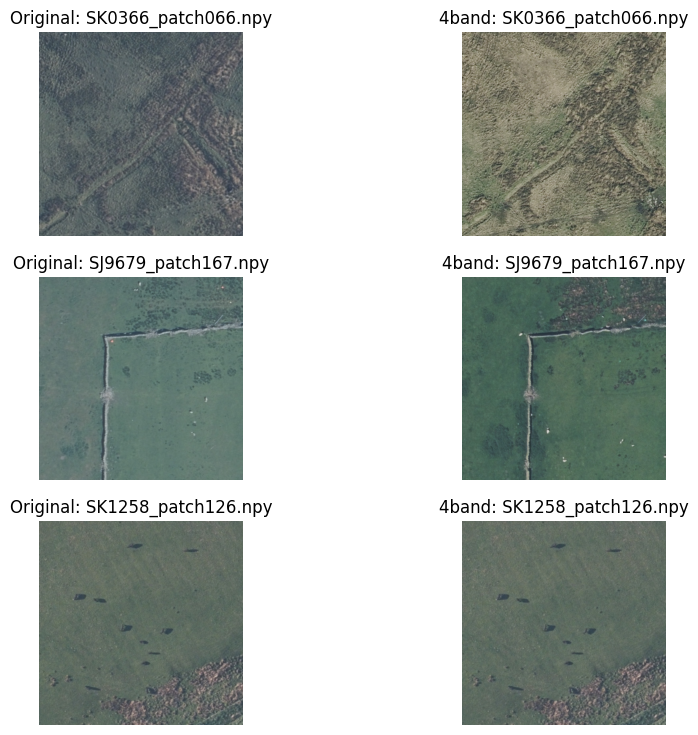

In [14]:
def load_specific_files(directory, filenames):
    """Load specified .npy files from a directory."""
    images = [np.load(os.path.join(directory, f)) for f in filenames if f in os.listdir(directory)]
    return images

def find_common_files(dir1, dir2):
    """Find common .npy files in two directories."""
    files1 = set(f for f in os.listdir(dir1) if f.endswith('.npy'))
    files2 = set(f for f in os.listdir(dir2) if f.endswith('.npy'))
    common_files = list(files1.intersection(files2))
    return common_files

def plot_images(images1, images2, filenames):
    """Plot pairs of images."""
    n = len(images1)
    plt.figure(figsize=(10, n * 3))
    for i in range(n):
        plt.subplot(n, 2, 2*i+1)
        img = images1[i]
        if img.ndim == 3 and img.shape[0] == 3:  # Assume three channels
            plt.imshow(img.transpose(1, 2, 0))
        elif img.ndim == 2:
            plt.imshow(img, cmap='gray')
        plt.title(f'Original: {filenames[i]}')
        plt.axis('off')

        plt.subplot(n, 2, 2*i+2)
        img = images2[i]
        if img.ndim == 3 and img.shape[0] == 3:
            plt.imshow(img.transpose(1, 2, 0))
        elif img.ndim == 2:
            plt.imshow(img, cmap='gray')
        plt.title(f'4band: {filenames[i]}')
        plt.axis('off')
    plt.show()

# Directories
dir_original = '/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format/images_python_all/'
dir_4band = '/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/images_python_all/'

# Find common files
common_files = find_common_files(dir_original, dir_4band)

# Randomly sample three files for comparison
sampled_files = random.sample(common_files, min(len(common_files), 3))

# Load images
images_original = load_specific_files(dir_original, sampled_files)
images_4band = load_specific_files(dir_4band, sampled_files)

# Plot images for comparison
plot_images(images_original, images_4band, sampled_files)


